## Generating flow records via NFStream

In [1]:
MAIN_OUTPUT_DIR = "NFS-2023-TE"
CSV_DIR = "datasets"

In [2]:
import os
import sys
from datetime import timedelta
import time
import logging
# from typing import OptionalZ
from nfstream import NFPlugin, NFStreamer
import nfstream
from labeller import cicids2017


# set up logging
def setup_logging(log_filename="generate-flows.log"):
    with open(
        os.path.join(MAIN_OUTPUT_DIR, log_filename), "w"
    ):  # Use 'w' to clear the existing log file, if it exists
        pass  # Do nothing, just open and close to clear the file

    logging.basicConfig(
        level=logging.INFO,
        format="%(message)s",
        handlers=[logging.FileHandler(os.path.join(MAIN_OUTPUT_DIR, log_filename)), logging.StreamHandler(sys.stdout)],
    )


class PayloadManager(NFPlugin):
    """Manages the payload data for network flows."""

    def on_init(self, packet, flow):
        # Initialize payload sizes based on the packet direction.
        flow.udps.src2dst_payload = packet.payload_size if packet.direction == 0 else 0
        flow.udps.dst2src_payload = packet.payload_size if packet.direction == 1 else 0

    def on_update(self, packet, flow):
        # Update payload sizes based on the packet direction.
        flow.udps.src2dst_payload += packet.payload_size if packet.direction == 0 else 0
        flow.udps.dst2src_payload += packet.payload_size if packet.direction == 1 else 0


class FlowExpirationManager(NFPlugin):
    """Manages the expiration policy for TCP flows."""

    def on_init(self, packet, flow):
        # Set the expiration ID based on TCP rst or fin flags.
        if packet.rst or packet.fin:
            flow.expiration_id = -1

    def on_update(self, packet, flow):
        # Update expiration policy based on TCP rst or fin flags.
        if packet.rst or packet.fin:
            flow.expiration_id = -1


class FlowLabelManager(NFPlugin):
    """Labels flows upon expiration."""

    def __init__(self, day):
        self.day = day

    def on_expire(self, flow):
        # Assign a label to the flow and clean up payloads.
        flow.udps.label = cicids2017(
            self.day, flow, label_reverse=True, signal_reverse=False
        )
        self.cleanup_payload(flow)

    @staticmethod
    def cleanup_payload(flow):
        # Clean up payload data from the flow.
        if hasattr(flow.udps, "src2dst_payload"):
            del flow.udps.src2dst_payload
        if hasattr(flow.udps, "dst2src_payload"):
            del flow.udps.dst2src_payload


def process_files_in_directory(input_dir: str, output_dir: str):
    """Process all PCAP files in a directory and output to another directory."""

    DAYS = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
    BPF = "ip and (ip proto \\tcp or \\udp)"  # only ipv4 tcp and udp traffic to capture

    for day in DAYS:
        input_file = os.path.join(input_dir, f"rd{day}.pcap")
        if os.path.isfile(input_file):
            output_file = os.path.join(output_dir, f"{day}.csv")
            logging.info(f"Processing {input_file} into {output_file}")

            start = time.time()

            streamer = NFStreamer(
                  source=input_file
                , decode_tunnels=False                                # Default: True
                , bpf_filter=BPF                                      # Default: None
                , promiscuous_mode=True                               # Default: True
                , snapshot_length=1536                                # Default: 1536
                , idle_timeout=60                                     # Default: 120
                , active_timeout=120                                  # Default: 1800
                , accounting_mode=0                                   # Default: 0
                , udps=[                                              # Default: None
                    FlowExpirationManager(),
                    PayloadManager(),
                    FlowLabelManager(day)
                ]      
                , n_dissections=0                                     # Default: 20
                , statistical_analysis=True                           # Default: False
                , splt_analysis=0                                     # Default: 0
                , n_meters=1                                          # Default: 0
                , performance_report=0                                # Default: 0
            )

            # Convert the stream to a DataFrame
            df = streamer.to_pandas(columns_to_anonymize=[])
            logging.info(f"NFStream generated flows: {len(df)}")

            end = time.time()
            processing_time = end - start
            delta = timedelta(seconds=processing_time)
            logging.info(f"Time required to generate flows: {str(delta)}")

            # Filter the DataFrame
            df_filtered = df[
                ~(
                    (df["bidirectional_packets"] == 1)
                    & (
                        (df["bidirectional_rst_packets"] == 1)
                        | (df["bidirectional_fin_packets"] == 1)
                    )
                )
            ]
            logging.info(f"Flows filtered: {len(df)-len(df_filtered)}")
            df = df_filtered

            # Save the filtered DataFrame to a CSV file
            df.rename(columns={"udps.label": "label"}, inplace=True)
            df.to_csv(output_file, index=False)

            logging.info(f"Flows stored after filtering: {len(df)}")
            logging.info(f"-----")


if __name__ == "__main__":
    input_dir = "./PCAP/deduplicated_reordered"
    output_dir = os.path.join(MAIN_OUTPUT_DIR, CSV_DIR) 
    
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    setup_logging()

    logging.info(f"NFStream version: {nfstream.__version__}")
    logging.info("NFStream processing started. Use Ctrl+C to interrupt and save.")
    logging.info(f"-----")
    process_files_in_directory(input_dir, output_dir)

NFStream version: 6.5.4
NFStream processing started. Use Ctrl+C to interrupt and save.
-----
Processing ./PCAP/deduplicated_reordered/rdMonday.pcap into NFS-2023-TE/datasets/Monday.csv
NFStream generated flows: 687767
Time required to generate flows: 0:06:03.034055
Flows filtered: 127992
Flows stored after filtering: 559775
-----
Processing ./PCAP/deduplicated_reordered/rdTuesday.pcap into NFS-2023-TE/datasets/Tuesday.csv
NFStream generated flows: 563175
Time required to generate flows: 0:06:11.543748
Flows filtered: 95921
Flows stored after filtering: 467254
-----
Processing ./PCAP/deduplicated_reordered/rdWednesday.pcap into NFS-2023-TE/datasets/Wednesday.csv
NFStream generated flows: 1085590
Time required to generate flows: 0:09:00.982193
Flows filtered: 220177
Flows stored after filtering: 865413
-----
Processing ./PCAP/deduplicated_reordered/rdThursday.pcap into NFS-2023-TE/datasets/Thursday.csv
NFStream generated flows: 553767
Time required to generate flows: 0:05:08.284197
Flows

## Determine dataset statistics

In [3]:
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")

# GLOBAL VARIABLES
MONDAY, TUESDAY, WEDNESDAY, THURSDAY, FRIDAY = "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"
DAYS = [MONDAY, TUESDAY, WEDNESDAY, THURSDAY, FRIDAY]
PATH = os.path.join(MAIN_OUTPUT_DIR, CSV_DIR) 

# Initializing the table.
header = ["DS", "TOTAL", "BENIGN", "ANOMALY", "NaN", "NaN_ROWS", "Anomaly breakdown"]
rowh = "{:^10}  "*(len(header)-1) + "{:^40}"
row = "{:^10}  "*(len(header)-1) + "{:<34}" + "{:>6}"
sep = ["-"*10]*(len(header)-1) + ["-"*40]
print(rowh.format(*header))

# nan_rows_dict = {} # Dictionary to store the number of NaN rows per CSV

for day in DAYS:
    print(rowh.format(*sep))

    # CSV
    csv = pd.read_csv(os.path.join(PATH,f"{day}.csv"))
    csv["label"].fillna('NaN', inplace=True)
    csv.dropna(inplace=True)

    TOTAL = len(csv)
    BENIGN = len(csv[csv["label"] == "BENIGN"])
    ANOMALY = len(csv[(csv["label"] != "BENIGN") & (csv["label"] != "NaN")])
    NaN = len(csv[csv["label"] == "NaN"])

    # Calculate NaN rows
    NaN_rows = pd.isnull(csv).any(axis=1).sum()
    # nan_rows_dict[day] = NaN_rows  # Store the count in the dictionary

    print(row.format(day, TOTAL, BENIGN, ANOMALY, NaN, NaN_rows, "", ""))
    for label in sorted(csv["label"].unique().tolist()):
        if label == "BENIGN" or label == "NaN":
            continue
        print(row.format("","","","","", "", label, len(csv[csv["label"] == label])))

    DS        TOTAL       BENIGN     ANOMALY       NaN       NaN_ROWS              Anomaly breakdown            
----------  ----------  ----------  ----------  ----------  ----------  ----------------------------------------
  Monday      559775      559775        0           0           0                                               
----------  ----------  ----------  ----------  ----------  ----------  ----------------------------------------
 Tuesday      467254      456311      10943         0           0                                               
                                                                        FTP-Patator                         7963
                                                                        SSH-Patator                         2980
----------  ----------  ----------  ----------  ----------  ----------  ----------------------------------------
Wednesday     865413      691015      174398        0           0                               

In [4]:
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")

# GLOBAL VARIABLES
MONDAY, TUESDAY, WEDNESDAY, THURSDAY, FRIDAY = "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"
DAYS = [MONDAY, TUESDAY, WEDNESDAY, THURSDAY, FRIDAY]

N = 1

# Initializing the table.
header = ["DS", "TOTAL", "BENIGN", "ANOMALY",
          f"T_FIN>{N}", f"B_FIN>{N}", f"A_FIN>{N}",
          f"T_RST>{N}", f"B_RST>{N}", f"A_RST>{N}"]
rowh = "{:^9}  "*(len(header))
row = "{:^9}  "*(len(header))
sep = ["-"*9]*(len(header)) + ["-"*39]
print(rowh.format(*header))

for day in DAYS:
    print(rowh.format(*sep))

    # CSV
    csv = pd.read_csv(os.path.join(PATH,f"{day}.csv"))
    csv.dropna(inplace=True) # Drop any rows with NaN values in any column

    TOTAL = len(csv)
    FIN_GT = len(csv[csv["bidirectional_fin_packets"] > N])
    RST_GT = len(csv[csv["bidirectional_rst_packets"] > N])
    BENIGN = len(csv[csv["label"] == "BENIGN"])
    BENIGN_FIN_GT = len(csv[(csv["label"] == "BENIGN") & (csv["bidirectional_fin_packets"] > N)])
    BENIGN_RST_GT = len(csv[(csv["label"] == "BENIGN") & (csv["bidirectional_rst_packets"] > N)])
    ANOMALY = len(csv[(csv["label"] != "BENIGN")])
    ANOMALY_FIN_GT = len(csv[(csv["label"] != "BENIGN") & (csv["bidirectional_fin_packets"] > N)])
    ANOMALY_RST_GT = len(csv[(csv["label"] != "BENIGN") & (csv["bidirectional_rst_packets"] > N)])

    print(row.format(day, TOTAL, BENIGN, ANOMALY,
                     FIN_GT, BENIGN_FIN_GT, ANOMALY_FIN_GT,
                     RST_GT, BENIGN_RST_GT, ANOMALY_RST_GT))

   DS        TOTAL     BENIGN     ANOMALY    T_FIN>1    B_FIN>1    A_FIN>1    T_RST>1    B_RST>1    A_RST>1   
---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  
 Monday     559775     559775        0          0          0          0          0          0          0      
---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  
 Tuesday    467254     456311      10943        0          0          0          0          0          0      
---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  
Wednesday   865413     691015     174398        0          0          0          0          0          0      
---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  
Thursday    485224     413744      71480        0          0          0          0          0          0      
-

In [5]:
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")

# GLOBAL VARIABLES
MONDAY, TUESDAY, WEDNESDAY, THURSDAY, FRIDAY = "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"
DAYS = [MONDAY, TUESDAY, WEDNESDAY, THURSDAY, FRIDAY]

N = 2

# Initializing the table.
header = ["DS", "TOTAL", "BENIGN", "ANOMALY",
          f"T_FIN>{N}", f"B_FIN>{N}", f"A_FIN>{N}",
          f"T_RST>{N}", f"B_RST>{N}", f"A_RST>{N}"]
rowh = "{:^9}  "*(len(header))
row = "{:^9}  "*(len(header))
sep = ["-"*9]*(len(header)) + ["-"*39]
print(rowh.format(*header))

for day in DAYS:
    print(rowh.format(*sep))

    # CSV
    csv = pd.read_csv(os.path.join(PATH,f"{day}.csv"))
    csv.dropna(inplace=True) # Drop any rows with NaN values in any column

    TOTAL = len(csv)
    FIN_GT = len(csv[csv["bidirectional_fin_packets"] > N])
    RST_GT = len(csv[csv["bidirectional_rst_packets"] > N])
    BENIGN = len(csv[csv["label"] == "BENIGN"])
    BENIGN_FIN_GT = len(csv[(csv["label"] == "BENIGN") & (csv["bidirectional_fin_packets"] > N)])
    BENIGN_RST_GT = len(csv[(csv["label"] == "BENIGN") & (csv["bidirectional_rst_packets"] > N)])
    ANOMALY = len(csv[(csv["label"] != "BENIGN")])
    ANOMALY_FIN_GT = len(csv[(csv["label"] != "BENIGN") & (csv["bidirectional_fin_packets"] > N)])
    ANOMALY_RST_GT = len(csv[(csv["label"] != "BENIGN") & (csv["bidirectional_rst_packets"] > N)])

    print(row.format(day, TOTAL, BENIGN, ANOMALY,
                     FIN_GT, BENIGN_FIN_GT, ANOMALY_FIN_GT,
                     RST_GT, BENIGN_RST_GT, ANOMALY_RST_GT))

   DS        TOTAL     BENIGN     ANOMALY    T_FIN>2    B_FIN>2    A_FIN>2    T_RST>2    B_RST>2    A_RST>2   
---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  
 Monday     559775     559775        0          0          0          0          0          0          0      
---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  
 Tuesday    467254     456311      10943        0          0          0          0          0          0      
---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  
Wednesday   865413     691015     174398        0          0          0          0          0          0      
---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  
Thursday    485224     413744      71480        0          0          0          0          0          0      
-

In [6]:
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")

# GLOBAL VARIABLES
MONDAY, TUESDAY, WEDNESDAY, THURSDAY, FRIDAY = "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"
DAYS = [MONDAY, TUESDAY, WEDNESDAY, THURSDAY, FRIDAY]

N = 3

# Initializing the table.
header = ["DS", "TOTAL", "BENIGN", "ANOMALY",
          f"T_FIN>{N}", f"B_FIN>{N}", f"A_FIN>{N}",
          f"T_RST>{N}", f"B_RST>{N}", f"A_RST>{N}"]
rowh = "{:^9}  "*(len(header))
row = "{:^9}  "*(len(header))
sep = ["-"*9]*(len(header)) + ["-"*39]
print(rowh.format(*header))

for day in DAYS:
    print(rowh.format(*sep))

    # CSV
    csv = pd.read_csv(os.path.join(PATH,f"{day}.csv"))
    csv.dropna(inplace=True) # Drop any rows with NaN values in any column

    TOTAL = len(csv)
    FIN_GT = len(csv[csv["bidirectional_fin_packets"] > N])
    RST_GT = len(csv[csv["bidirectional_rst_packets"] > N])
    BENIGN = len(csv[csv["label"] == "BENIGN"])
    BENIGN_FIN_GT = len(csv[(csv["label"] == "BENIGN") & (csv["bidirectional_fin_packets"] > N)])
    BENIGN_RST_GT = len(csv[(csv["label"] == "BENIGN") & (csv["bidirectional_rst_packets"] > N)])
    ANOMALY = len(csv[(csv["label"] != "BENIGN")])
    ANOMALY_FIN_GT = len(csv[(csv["label"] != "BENIGN") & (csv["bidirectional_fin_packets"] > N)])
    ANOMALY_RST_GT = len(csv[(csv["label"] != "BENIGN") & (csv["bidirectional_rst_packets"] > N)])

    print(row.format(day, TOTAL, BENIGN, ANOMALY,
                     FIN_GT, BENIGN_FIN_GT, ANOMALY_FIN_GT,
                     RST_GT, BENIGN_RST_GT, ANOMALY_RST_GT))

   DS        TOTAL     BENIGN     ANOMALY    T_FIN>3    B_FIN>3    A_FIN>3    T_RST>3    B_RST>3    A_RST>3   
---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  
 Monday     559775     559775        0          0          0          0          0          0          0      
---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  
 Tuesday    467254     456311      10943        0          0          0          0          0          0      
---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  
Wednesday   865413     691015     174398        0          0          0          0          0          0      
---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  
Thursday    485224     413744      71480        0          0          0          0          0          0      
-

In [7]:
for day in DAYS:
    csv = pd.read_csv(os.path.join(PATH,f"{day}.csv"))
    csv.dropna(inplace=True) # Drop any rows with NaN values in any column
    print(day)
    print(csv[['bidirectional_fin_packets', 'bidirectional_rst_packets']].describe())
    print("\n")

Monday
       bidirectional_fin_packets  bidirectional_rst_packets
count              559775.000000              559775.000000
mean                    0.352949                   0.041511
std                     0.477887                   0.199470
min                     0.000000                   0.000000
25%                     0.000000                   0.000000
50%                     0.000000                   0.000000
75%                     1.000000                   0.000000
max                     1.000000                   1.000000


Tuesday
       bidirectional_fin_packets  bidirectional_rst_packets
count              467254.000000              467254.000000
mean                    0.325590                   0.042882
std                     0.468595                   0.202592
min                     0.000000                   0.000000
25%                     0.000000                   0.000000
50%                     0.000000                   0.000000
75%                    

In [8]:
import pandas as pd
import os
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# GLOBAL VARIABLES
MONDAY, TUESDAY, WEDNESDAY, THURSDAY, FRIDAY = "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"
DAYS = [MONDAY, TUESDAY, WEDNESDAY, THURSDAY, FRIDAY]
N=5

for day in DAYS:
    # Read the CSV file
    csv = pd.read_csv(os.path.join(PATH, f"{day}.csv"))
    csv.dropna(inplace=True)  # Drop any rows with NaN values in any column

    # # Get descriptive statistics
    print(f"Statistics for {day}:")
    # stats = csv[['bidirectional_fin_packets', 'bidirectional_rst_packets']].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 1.0])
    # print(stats)

    # Print the top N value counts for each column without the index name and series description
    fin_counts = csv['bidirectional_fin_packets'].value_counts().head(N).to_string(header=False, index=True)
    rst_counts = csv['bidirectional_rst_packets'].value_counts().head(N).to_string(header=False, index=True)
    
    print(f"\nTop {N} Value Counts for FIN Packets:")
    print(fin_counts)
    
    print(f"\nTop {N} Value Counts for RST Packets:")
    print(rst_counts)
    
    print("\n" + "-"*50 + "\n")

Statistics for Monday:

Top 5 Value Counts for FIN Packets:
0    362203
1    197572

Top 5 Value Counts for RST Packets:
0    536538
1     23237

--------------------------------------------------

Statistics for Tuesday:

Top 5 Value Counts for FIN Packets:
0    315121
1    152133

Top 5 Value Counts for RST Packets:
0    447217
1     20037

--------------------------------------------------

Statistics for Wednesday:

Top 5 Value Counts for FIN Packets:
0    491185
1    374228

Top 5 Value Counts for RST Packets:
0    685035
1    180378

--------------------------------------------------

Statistics for Thursday:

Top 5 Value Counts for FIN Packets:
0    350493
1    134731

Top 5 Value Counts for RST Packets:
0    437927
1     47297

--------------------------------------------------

Statistics for Friday:

Top 5 Value Counts for FIN Packets:
0    553124
1    222570

Top 5 Value Counts for RST Packets:
0    494409
1    281285

--------------------------------------------------



## Plot Sankey diagrams

Friday


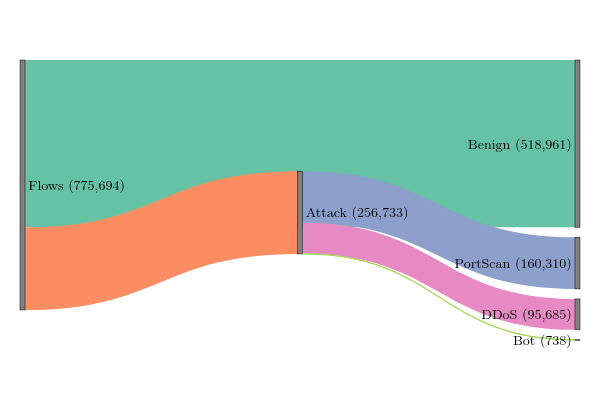

Monday


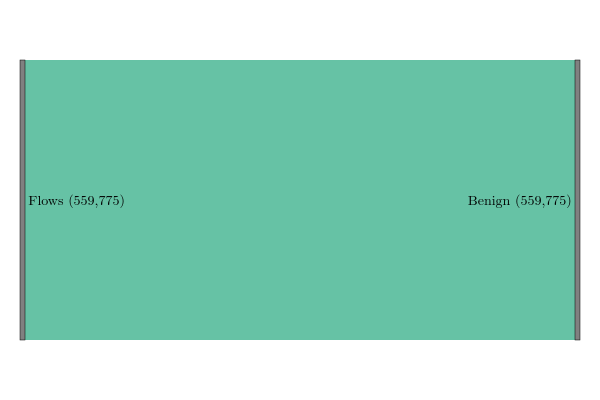

Thursday


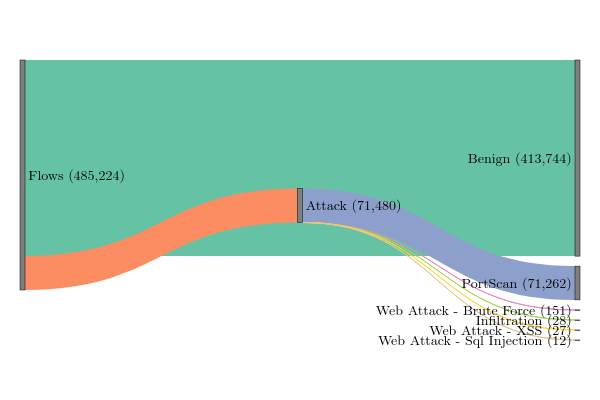

Tuesday


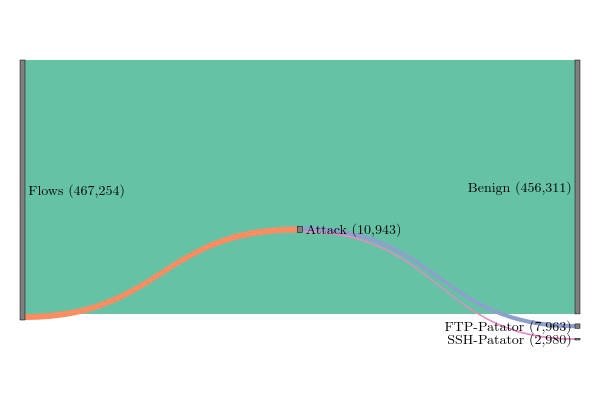

Wednesday


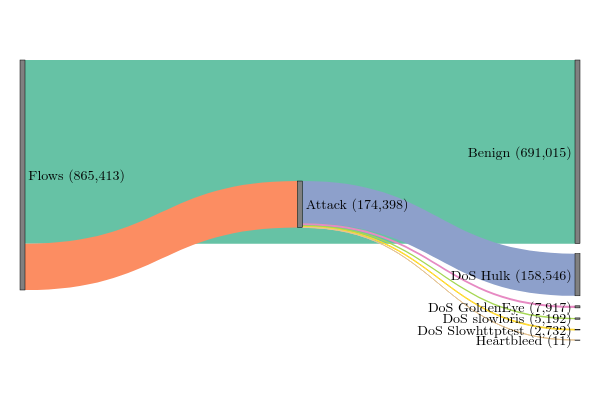

In [9]:
import glob
import os
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import json

# Create the directory if it doesn't exist
if not os.path.exists(os.path.join(MAIN_OUTPUT_DIR,'sankey-plots')):
    os.makedirs(os.path.join(MAIN_OUTPUT_DIR,'sankey-plots'))

# Find all CSV files in the local directory and sort them in alphabetical order
csv_files = sorted(glob.glob(f'{PATH}/*.csv'))

# Set the color palette
color_palette = px.colors.qualitative.Set2

# Create an empty dictionary to hold the summary data
summary = {}

for csv_file in csv_files:
    # Read the CSV file
    df = pd.read_csv(csv_file)

    # Extract the day (filename without extension) from the CSV file's name
    day = os.path.splitext(os.path.basename(csv_file))[0]
    print(day)

    # Count the total number of rows, benign rows, and attack rows
    total_rows = len(df)
    benign_rows = len(df[df['label'] == 'BENIGN'])
    attack_rows = total_rows - benign_rows

    # Find the unique attack types and their counts
    attack_types = df[df['label'] != 'BENIGN']['label'].value_counts()

    # Define the nodes of the Sankey diagram
    nodes = [
        dict(label=f'Flows ({total_rows:,})'),  # Include thousands separator
        dict(label=f'Benign ({benign_rows:,})'),  # Include thousands separator
        dict(label=f'Attack ({attack_rows:,})'),  # Include thousands separator
    ]
    nodes.extend(dict(label=f'{attack_type} ({count:,})') for attack_type, count in
                 attack_types.items())  # Include thousands separator

    # Create a hierarchy for the current day and add it to the main dictionary
    summary[day] = {
        "Total Flows": total_rows,
        "Benign": benign_rows,
        "Attack": {
            "Total Attack Flows": attack_rows,
            "Attack Types": attack_types.to_dict()  # Convert Series to dictionary
        }
    }
    
    # Define the links of the Sankey diagram
    links = [
        dict(source=0, target=1, value=benign_rows, color=color_palette[0]),
        dict(source=0, target=2, value=attack_rows, color=color_palette[1]),
    ]
    links.extend(dict(source=2, target=i+3, value=count, color=color_palette[(i+2)%len(color_palette)]) for i, count in enumerate(attack_types))

    # Create the Sankey diagram figure
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=10,  # Reduce padding between nodes
            thickness=5,  # Reduce node thickness
            line=dict(color='black', width=0.5),
            label=[node['label'] for node in nodes],
            color='gray'  # Change node color for better print readability
        ),
        link=dict(
            source=[link['source'] for link in links],
            target=[link['target'] for link in links],
            value=[link['value'] for link in links],
            color=[link['color'] for link in links]  # Set link color
        )
    )])

    # Customize the layout of the Sankey diagram
    fig.update_layout(
        # title_text=f'Sankey Diagram for {csv_file}',
        font=dict(
            family='CMU Serif',
            size=14,  # Reduce font size
            color='black'  # Change font color to black for better print readability
        ),
        autosize=True,  # Make the layout tight
        width=600,  # Reduce figure width
        height=400,  # Reduce figure height
        # paper_bgcolor='white',  # Change background color to white for better print readability
        paper_bgcolor='rgba(0,0,0,0)',  # Set paper background to transparent
        # plot_bgcolor='white'  # Change plot background color to white for better print readability
        plot_bgcolor='rgba(0,0,0,0)',  # Set plot background to transparent
        margin = dict(l=20, r=20, t=60, b=60)  # Reduce margins
    )

    # Show the plot
    # pyo.iplot(fig)

    # Show the plot as a static image
    img_bytes = pio.to_image(fig, format='png')
    from IPython.display import Image, display
    display(Image(img_bytes))
    
    # Save the Sankey diagram as a PNG file
    pio.write_image(fig, f'{MAIN_OUTPUT_DIR}/sankey-plots/{os.path.splitext(os.path.basename(csv_file))[0]}_sankey.png', scale=5)

with open(os.path.join(MAIN_OUTPUT_DIR, "flow-distribution-summary.json"), "w") as outfile:
    json.dump(summary, outfile, indent=4)

## Plot flow CDFs

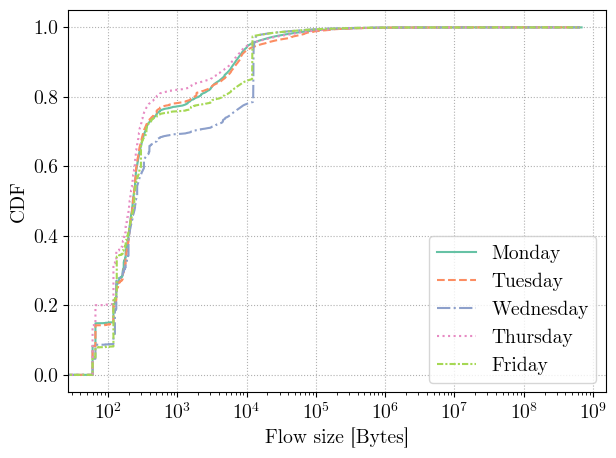

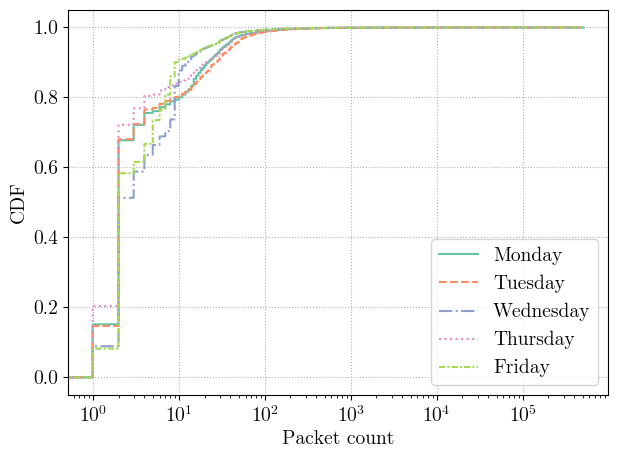

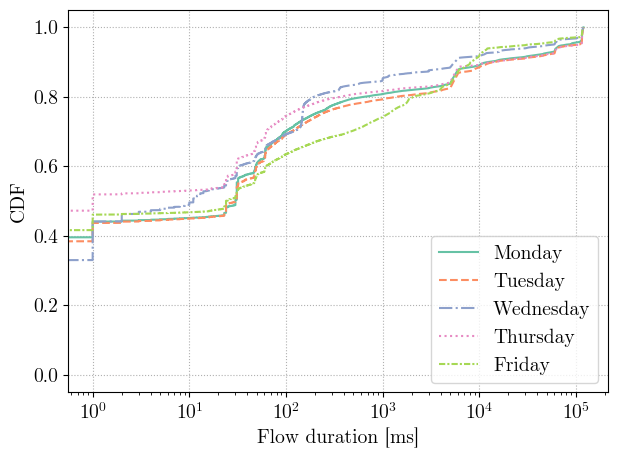

In [10]:
import pandas as pd
import os
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import seaborn as sns

# Create the directory if it doesn't exist
if not os.path.exists(os.path.join(MAIN_OUTPUT_DIR,'flow-CDF-plots')):
    os.makedirs(os.path.join(MAIN_OUTPUT_DIR,'flow-CDF-plots'))

def plot_ecdf(data, label, linestyle, color):
    plt.plot(data.x, data.y, label=label, color=color, ls=linestyle)
    plt.grid(True)

def configure_plot(font_family="CMU Serif", font_size=14):
    plt.rc('grid', linestyle=":")
    plt.rc('text', usetex=False)
    plt.rcParams["font.family"] = font_family
    plt.rcParams.update({"font.size": font_size})

def sort_by_weekday(filename):
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    for index, day in enumerate(weekday_order):
        if day in filename:
            return index
    return -1  # In case the filename doesn't contain a weekday

def main(legend_labels=None):
    path_in = os.path.join(PATH, "")
    path_out = os.path.join(MAIN_OUTPUT_DIR,'flow-CDF-plots')

    csv_files = [f for f in os.listdir(path_in) if f.endswith('.csv')]
    csv_files.sort(key=sort_by_weekday)

    linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]
    colors = sns.color_palette('Set2', len(csv_files))

    configure_plot()

    for metric, xlabel in [('bidirectional_bytes', 'Flow size [Bytes]'),
                           ('bidirectional_packets', 'Packet count'),
                           ('bidirectional_duration_ms', 'Flow duration [ms]')]:
        plt.figure()
        for i, csv_file in enumerate(csv_files):
            data = pd.read_csv(path_in + csv_file, sep=",", skip_blank_lines=True)
            label = legend_labels[i] if legend_labels else csv_file
            plot_ecdf(ECDF(data[metric]), label, linestyles[i % len(linestyles)], colors[i % len(colors)])
        plt.xscale('log')
        plt.xlabel(xlabel)
        plt.ylabel('CDF')
        plt.legend(loc='best')
        plt.tight_layout()
        plt.savefig(os.path.join(path_out, f'all-days-{metric}-cdf.png'), format='png', dpi=300)

if __name__ == "__main__":
    main(
        legend_labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    )